
# Initialize

In [1]:
import sys
sys.path.append("/media/hdd/viscent/SR-UNet")
from utils.inference_utils import *

In [2]:
dhcp_train_loader, dhcp_test_loader, dhcp_val_loader = get_dataloader('dhcp',100,modality='t2')
hcp_train_loader, hcp_test_loader, hcp_val_loader = get_dataloader('hcp',100,modality='t2')

dhcp_t2_1500 = load_model('/media/hdd/viscent/SR-UNet/pretrained_models/dhcp_t2_1500.pth')
dhcp_t2_1500_aug = load_model('/media/hdd/viscent/SR-UNet/pretrained_models/dhcp_t2_1500_aug.pth')
hcp_t2_140_aug = load_model('/media/hdd/viscent/SR-UNet/pretrained_models/hcp_t2_140_aug.pth')

hcp_t2_140_aug.eval()
hcp_t2_140_aug.cuda()
dhcp_t2_1500.eval()
dhcp_t2_1500.cuda()
dhcp_t2_1500_aug.eval()
dhcp_t2_1500_aug.cuda()

[09/12/22 19:41:17] INFO     colossalai - root - INFO: Creating dataset with 80 examples

                    INFO     colossalai - root - INFO: length of list_images_t1: 80

  0%|          | 0/80 [00:00<?, ?it/s]

[09/12/22 19:41:20] INFO     colossalai - root - INFO: Creating dataset with 20 examples

                    INFO     colossalai - root - INFO: length of list_images_t1: 20

  0%|          | 0/20 [00:00<?, ?it/s]

                    INFO     colossalai - root - INFO: Creating dataset with 80 examples

  0%|          | 0/80 [00:00<?, ?it/s]

[09/12/22 19:41:22] INFO     colossalai - root - INFO: Creating dataset with 20 examples

  0%|          | 0/20 [00:00<?, ?it/s]

BUNet3D(
  (encoders): ModuleList(
    (0): Encoder(
      (basic_module): DoubleConv(
        (SingleConv1): SingleConv(
          (groupnorm): GroupNorm(1, 1, eps=1e-05, affine=True)
          (conv): Conv3d(1, 8, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1), bias=False)
          (ReLU): ReLU(inplace=True)
        )
        (SingleConv2): SingleConv(
          (groupnorm): GroupNorm(1, 8, eps=1e-05, affine=True)
          (conv): Conv3d(8, 16, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1), bias=False)
          (ReLU): ReLU(inplace=True)
        )
      )
    )
    (1): Encoder(
      (pooling): MaxPool3d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (basic_module): DoubleConv(
        (SingleConv1): SingleConv(
          (groupnorm): GroupNorm(1, 16, eps=1e-05, affine=True)
          (conv): Conv3d(16, 16, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1), bias=False)
          (ReLU): ReLU(inplace=True)
        )
       

In [3]:
data_root = '/media/hdd/viscent/FLYWHEEL_BROWN/BROWN/SUBJECTS'
subject_list = os.listdir(data_root)
# Exclude hidden files
subject_list = [x for x in subject_list if not x.startswith('.')]
t2_file_list = []
for subject in subject_list:
    tmp = os.listdir(os.path.join(data_root, subject, 'SESSIONS'))
    tmp = [x for x in tmp if not x.startswith('.')]
    session = tmp[0]
    tmp = os.listdir(os.path.join(data_root, subject, 'SESSIONS', session, 'ACQUISITIONS'))
    tmp = [x for x in tmp if x.find('T2') != -1 and x.find('AXI') != -1 and not x.startswith('.')]
    if len(tmp) == 0:
        continue
    nifti_dir = os.path.join(data_root, subject, 'SESSIONS', session, 'ACQUISITIONS', tmp[0], 'FILES')
    nifti_file = os.listdir(nifti_dir)
    nifti_file = [x for x in nifti_file if x.endswith('.nii.gz') and not x.startswith('.')][0]
    t2_file_list.append(os.path.join(nifti_dir, nifti_file))


In [4]:
images = []
image_tensors = []
for t2_file in t2_file_list:
    images.append(sitk.ReadImage(t2_file))
    subject = tio.Subject(t2=tio.ScalarImage(t2_file))
    transform_1 = tio.Compose([
        tio.transforms.RescaleIntensity(0., 1.),
        tio.transforms.ToCanonical(),
        tio.transforms.Resample((1.,1.,1.)),
    ])
    subject = transform_1(subject)
    edge_max = max(subject.t2.data.shape)
    padding = ((edge_max - subject.t2.data.shape[1]) // 2, 
                (edge_max - subject.t2.data.shape[2]) // 2,
                    (edge_max - subject.t2.data.shape[3]) // 2)
    transform_2 = tio.Compose([
        tio.Pad(padding),
        tio.transforms.Resize((160,160,160)),
    ])
    subject = transform_2(subject)
    image_tensor = subject.t2.data.unsqueeze(0).float()
    image_tensors.append(image_tensor)

/home/viscent/anaconda3/envs/bunet/lib/python3.10/site-packages/torchio/transforms/preprocessing/intensity/rescale.py:99: RuntimeWarning:

Rescaling image "t2" not possible because all the intensity values are the same



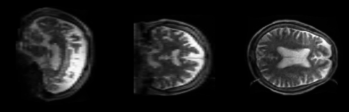

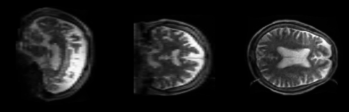

In [5]:
display_multiplanar_center(image_tensors[1][0,0])

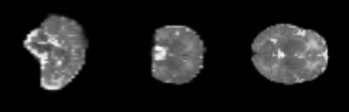

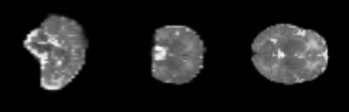

In [6]:
display_multiplanar_center(iter(dhcp_test_loader).next()[0][0,0])

In [14]:
import os


output_tensors_dhcp_1500 = []
output_tensors_dhcp_1500_aug = []
output_tensors_hcp_140_aug = []

data_root = '/media/hdd/viscent/FLYWHEEL_BROWN/'

outdir_dhcp_1500 = os.path.join(data_root, 'output_dhcp_1500')
outdir_dhcp_1500_aug = os.path.join(data_root, 'output_dhcp_1500_aug')
outdir_hcp_140_aug = os.path.join(data_root, 'output_hcp_140_aug')
os.mkdir(outdir_dhcp_1500)
os.mkdir(outdir_dhcp_1500_aug)
os.mkdir(outdir_hcp_140_aug)


for image_tensor in tqdm(image_tensors):
    output_tensor_dhcp_1500 = dhcp_t2_1500(image_tensor.cuda()).cpu().detach()
    output_tensor_dhcp_1500_aug = dhcp_t2_1500_aug(image_tensor.cuda()).cpu().detach()
    output_tensor_hcp_140_aug = hcp_t2_140_aug(image_tensor.cuda()).cpu().detach()
    output_tensors_dhcp_1500.append(output_tensor_dhcp_1500)
    output_tensors_dhcp_1500_aug.append(output_tensor_dhcp_1500_aug)
    output_tensors_hcp_140_aug.append(output_tensor_hcp_140_aug)
    sitk.WriteImage(sitk.GetImageFromArray(output_tensor_dhcp_1500[0,0].numpy()), os.path.join(outdir_dhcp_1500, 'output.nii.gz'))
    sitk.WriteImage(sitk.GetImageFromArray(output_tensor_dhcp_1500_aug[0,0].numpy()), os.path.join(outdir_dhcp_1500_aug, 'output.nii.gz'))
    sitk.WriteImage(sitk.GetImageFromArray(output_tensor_hcp_140_aug[0,0].numpy()), os.path.join(outdir_hcp_140_aug, 'output.nii.gz'))

PermissionError: [Errno 13] Permission denied: '/media/hdd/viscent/FLYWHEEL_BROWN/BROWN/SUBJECTS/output_dhcp_1500'